In [3]:
import os
import shutil
import time
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score

In [4]:
# Define the path to the augmented dataset
data_path = '/Users/jexpatel/Desktop/Image_Classification/Augmented Dataset'

# Define the paths to the training, validation, and testing folders
train_path = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Train'
valid_path = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Valid'
test_path = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Test'

# Define the class names
class_names = ['Core', 'Well Logs']

# Create the training, validation, and testing folders and subfolders
for folder in [train_path, valid_path, test_path]:
    for class_name in class_names:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

# Loop through the class names
for class_name in class_names:
    # Get the path to the class folder in the augmented dataset
    class_path = os.path.join(data_path, class_name)
    
    # Get the file names in the class folder
    file_names = os.listdir(class_path)
    
    # Shuffle the file names
    random.shuffle(file_names)
    
    # Split the file names into training, validation, and testing sets
    train_split_index = int(len(file_names) * 0.35)
    valid_split_index = int(len(file_names) * 0.7)
    train_file_names = file_names[:train_split_index]
    valid_file_names = file_names[train_split_index:valid_split_index]
    test_file_names = file_names[valid_split_index:]
    
    # Move the training files to the training folder
    for file_name in train_file_names:
        src_path = os.path.join(class_path, file_name)
        dst_path = os.path.join(train_path, class_name, file_name)
        shutil.copyfile(src_path, dst_path)
        
    # Move the validation files to the validation folder
    for file_name in valid_file_names:
        src_path = os.path.join(class_path, file_name)
        dst_path = os.path.join(valid_path, class_name, file_name)
        shutil.copyfile(src_path, dst_path)
        
    # Move the testing files to the testing folder
    for file_name in test_file_names:
        src_path = os.path.join(class_path, file_name)
        dst_path = os.path.join(test_path, class_name, file_name)
        shutil.copyfile(src_path, dst_path)

    

In [5]:
# Define paths to the training data
train_data_dir = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Train'
test_data_dir = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Test'
valid_data_dir = '/Users/jexpatel/Desktop/Image_Classification/Split Data/Valid'

# Define data generators for training, validation, and test data
batch_size = 32
epochs = 10
num_classes = len(os.listdir(train_data_dir))

In [6]:
# Train the model on the new dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.2)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 571 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [21]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation, with L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.1))(x)

# Add a dropout layer with a rate of 0.5
x = Dropout(rate=0.8)(x)

# Add an output layer with as many neurons as the number of classes to predict
predictions = Dense(num_classes, activation='softmax')(x)

# Define the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
NAME = "Image_Classification{}".format(int(time.time()))

# Define logs path for model logs
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME), histogram_freq=1)

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[tensorboard])

Epoch 1/10
18/18 [==============================] - 85s 5s/step - loss: 80.3888 - accuracy: 0.7324 - val_loss: 33.9668 - val_accuracy: 0.8809
Epoch 2/10
18/18 [==============================] - 82s 5s/step - loss: 17.2267 - accuracy: 0.7975 - val_loss: 6.1548 - val_accuracy: 0.8406
Epoch 3/10
18/18 [==============================] - 82s 5s/step - loss: 3.4594 - accuracy: 0.8275 - val_loss: 1.7159 - val_accuracy: 0.9527
Epoch 4/10
18/18 [==============================] - 82s 5s/step - loss: 1.4844 - accuracy: 0.8468 - val_loss: 1.0762 - val_accuracy: 0.9194
Epoch 5/10
18/18 [==============================] - 82s 5s/step - loss: 1.0924 - accuracy: 0.8521 - val_loss: 0.8260 - val_accuracy: 0.9335
Epoch 6/10
18/18 [==============================] - 81s 5s/step - loss: 0.9048 - accuracy: 0.8539 - val_loss: 0.7603 - val_accuracy: 0.8739
Epoch 7/10
18/18 [==============================] - 82s 5s/step - loss: 0.7718 - accuracy: 0.8398 - val_loss: 0.5956 - val_accuracy: 0.9422
Epoch 8/10
18/18 

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2, callbacks=[tensorboard])
print('Test accuracy:', test_acc)

17/17 - 36s - loss: 0.4517 - accuracy: 0.9540
Test accuracy: 0.954023003578186


Classification Report:
               precision    recall  f1-score   support

        Core       0.50      0.55      0.52       262
   Well Logs       0.50      0.45      0.47       260

    accuracy                           0.50       522
   macro avg       0.50      0.50      0.50       522
weighted avg       0.50      0.50      0.50       522

F1 Score: 0.4969320241378409
Recall: 0.49808429118773945
Accuracy: 0.49808429118773945
Precision: 0.4978894733424248


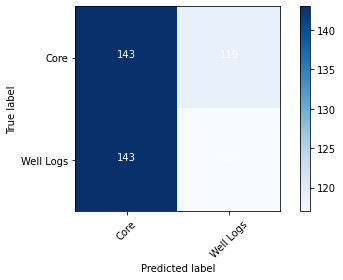

In [16]:
# Get the true labels and predicted labels from the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

# Create a classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', report)

# Calculate the f1 score, recall and precision
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
print('F1 Score:', f1)
print('Recall:', recall)
print('Accuracy:', accuracy)
print('Precision:', precision)

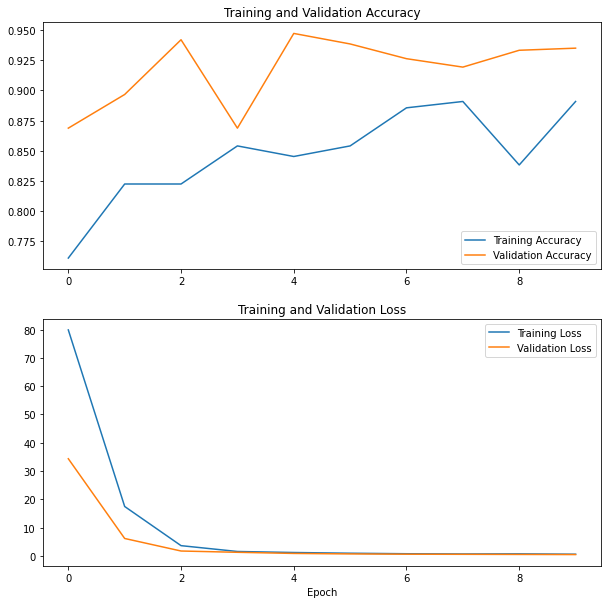

In [17]:
# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [18]:
#Launch TensroBoard in the command line
#tensorboard --logdir=logs/